### Asistente con Nodos de recuperacion de archivos opcionales y almacenamiento de vectores en sqlite

In [12]:
#segmentacion de docs
from langchain_community.document_loaders import TextLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter

#Vector store
import sqlite3
from langchain_community.vectorstores import SQLiteVec


# llms
from langchain_openai import ChatOpenAI
from langchain_huggingface import HuggingFaceEmbeddings

#Langgraph modules
from langgraph.graph import START, StateGraph
from langchain_core.prompts import PromptTemplate

# python common modules
from IPython.display import Image, display
from typing_extensions import Annotated, List, TypedDict
from typing import Literal
from dotenv import load_dotenv
from pathlib import Path

import os

load_dotenv()
#

base_dir = Path.cwd()
leyes_dir = base_dir / "leyes"  # Adjust this path based on your actual directory structure

# If leyes_dir doesn't exist, try going up one level
if not leyes_dir.exists():
    leyes_dir = base_dir.parent / "leyes"

Cargamos el modelo de deepseek

In [13]:
openai_api_key = os.getenv("DEEPSEEK_API_KEY")
openai_base_url = os.getenv("DEEPSEEK_API_URL")
openai_model = os.getenv("LLM_MODEL")

# Crear una instancia del modelo ChatOpenAI
llm = ChatOpenAI(
    # base_url=openai_base_url,
    # api_key=openai_api_key,
    model= "gpt-4o",
    temperature=0.5, 
)

Definir base de datos

In [ ]:
db_path = base_dir / "Database/leyes.db"
db_path.parent.mkdir(parents=True, exist_ok=True) 

db: sqlite3 = SQLiteVec.create_connection(db_path)

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")  
vector_store = SQLiteVec(
    table="leyes",
    connection=db,
    embedding=embeddings,
    db_file=None,
)   

Cargar un documento

In [15]:
def split_doc(file_path: str) -> List[Document] :
    loader = TextLoader(file_path , encoding='utf-8')
    leyes = loader.load()
    
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    docs = text_splitter.split_documents(leyes)
    
    return docs

Cargar documentos de transito a la base de datos

In [4]:
def add_doc_to_vector_db(vector_store: SQLiteVec, docs: List[Document]):
    vector_store.add_documents(docs)
    

# Load all laws from the directory
for file in os.listdir(leyes_dir):
    file_path = os.path.join(leyes_dir, file)
    print(f"Adding {file_path} to the vector store...")
    if os.path.isfile(file_path) and file.endswith('.txt'):
        docs = split_doc(file_path)
        add_doc_to_vector_db(vector_store, docs)

Adding e:\Code\Python\Asistente-Legal-API\App\leyes\1973-BO-COD-DL10135.txt to the vector store...
Adding e:\Code\Python\Asistente-Legal-API\App\leyes\1978-BO-RE-RS187444(1).txt to the vector store...
Adding e:\Code\Python\Asistente-Legal-API\App\leyes\2006-BO-DS-28710.txt to the vector store...
Adding e:\Code\Python\Asistente-Legal-API\App\leyes\2008-BO-L-3988.txt to the vector store...
Adding e:\Code\Python\Asistente-Legal-API\App\leyes\2010-BO-DS-N420.txt to the vector store...
Adding e:\Code\Python\Asistente-Legal-API\App\leyes\2011-BO-L-N145.txt to the vector store...
Adding e:\Code\Python\Asistente-Legal-API\App\leyes\2014-BO-DS-N2079.txt to the vector store...
Adding e:\Code\Python\Asistente-Legal-API\App\leyes\2017-BO-DS-N3045.txt to the vector store...
Adding e:\Code\Python\Asistente-Legal-API\App\leyes\2022-BO-DS-N4740.txt to the vector store...
Adding e:\Code\Python\Asistente-Legal-API\App\leyes\2022-BO-DS-N4780.txt to the vector store...
Adding e:\Code\Python\Asistente-Lega

definimos el prompt a usar

In [ ]:
template = """ Responde exclusivamente en español. 
Eres un asistente legal que puede responder preguntas sobre el 
reglamento de tránsito boliviano.
Usa solamente información de la referencia para responder. 
En caso de que no encuentres la respuesta en la referencia, responde con "No tengo información sobre eso".
En tu respuesta referencia el articulo que corresponda a tu respuesta.

Usa la siguiente información como referencia: 
{context}

Responde a la siguiente pregunta:
{question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

Hacemos la recuperacion de documentos una herramienta para que sea opcionalmente llamado por el agente

In [22]:
from langchain_core.tools import tool

numero_docs_recuperados: int  = 4

@tool(response_format="content_and_artifact")
def recuperarDocs(query: str):
    """Retrieve information related to a query."""
    # Create a new connection each time the function is called
    db_path_str = str(base_dir / "Database/leyes.db")
    
    # Create a new vector store with a new connection
    vector_store = SQLiteVec(
    table="leyes",
    connection=None,
    embedding=embeddings,
    db_file=db_path_str,
    )   

    retrieved_docs = vector_store.similarity_search(query, k=numero_docs_recuperados)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

tools = [recuperarDocs]
llm_with_tools = llm.bind_tools(tools)

Creamos el nodo donde se usará la herramienta

In [27]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(
   content="""Responde exclusivamente en español. 
      Eres un asistente legal que puede responder preguntas sobre el reglamento de tránsito boliviano.
      Usa solamente información de la referencia para responder. 
      En caso de que no encuentres la respuesta en la referencia, responde con "No tengo información sobre eso".
      En tu respuesta referencia el articulo que corresponda a tu respuesta."""
   )

# Node
def recuperar_o_responder(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

Definimos el grafo

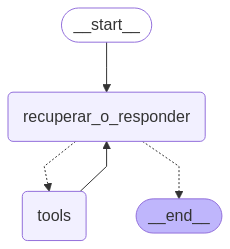

In [28]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
grafo = StateGraph(MessagesState)

# Define nodes: these do the work
grafo.add_node("recuperar_o_responder", recuperar_o_responder)
grafo.add_node("tools", ToolNode(tools)) # cargando la lista de herramientas

# Define edges: these determine how the control flow moves
grafo.add_edge(START, "recuperar_o_responder")
grafo.add_conditional_edges(
    "recuperar_o_responder",
    tools_condition,
)
grafo.add_edge("tools", "recuperar_o_responder")
react_graph = grafo.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

Probamos con mensajes guardados

In [30]:
messages = [HumanMessage(content="existe una multa por circular sin brevet?")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

existe una multa por circular sin brevet?
================================== Ai Message ==================================
Tool Calls:
  recuperarDocs (call_aZh8kvH1izkl3Djqn7mz8xaP)
 Call ID: call_aZh8kvH1izkl3Djqn7mz8xaP
  Args:
    query: multa por circular sin brevet en Bolivia
================================= Tool Message =================================
Name: recuperarDocs

Source: {'source': 'e:\\Code\\Python\\Asistente-Legal-API\\App\\leyes\\1978-BO-RE-RS187444(1).txt'}
Content: VEINTE PESOS BOLIVIANOS ($b. 20.-) de multa.
 13. Por conducir vehículos sin portar la licencia brevet o autorización, con
     VEINTE PESOS BOLIVIANOS ($b. 20.-) de multa.
 14. Por conversar o distraer el pasajero al conductor de un vehículo de
     servicio colectivo de pasajeros que está en marcha, con VEINTE PESOS
     BOLIVIANOS ($b. 20.-) de multa.
 15. Por negarse injustificadamente el usuario a cancelar la tarifa